In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import cv2
import pandas as pd

plt.style.use('ggplot')

In [2]:
DATASET_DIR="../dataset/10/"

In [50]:
def plot_cumulative_error(algorithm_errors : list[np.ndarray],
                          titles : list[str],
                          ) -> None:
    total_samples = len(algorithm_errors[0])
    errors = []
    for err in algorithm_errors:
        errors.extend(err)
    x_values = sorted(set(errors))
    
    fig, ax = plt.subplots()
   
    # Plot cumulative error distribution
    for errors, title in zip(algorithm_errors, titles):
        alg_err_dist = [sum(1 for error in errors if error <= x) / total_samples for x in x_values]
        ax.plot(x_values, alg_err_dist, label=title)
        
    ax.set_ylabel("Percentage of Images")
    ax.set_xlabel("Detection Error")
    ax.set_title("Cumulative Error Distribution of Each Algorithm")

    # Set tick labels with units using formatters
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.0f}px"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{y*100:.0f}%"))

    ax.legend()
    plt.show()


In [44]:
def dummy_method(image: np.ndarray):
    return image.shape[0]//2, image.shape[1]//2

### NOTA

Hay mas anotaciones que imagenes, fijarse bien el tema de las anotaciones 
como se indexan y eso, a que frame corresponde cada point anotation

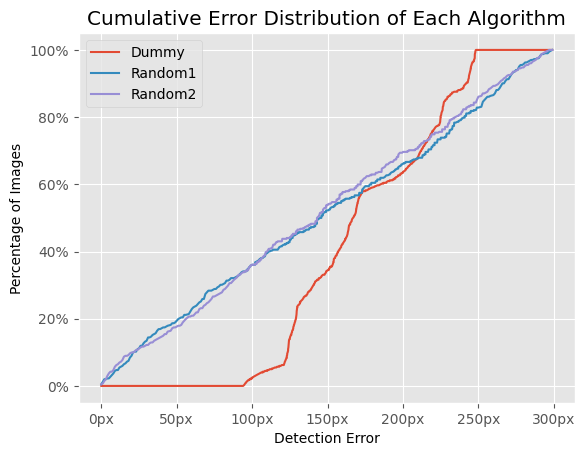

In [53]:
import glob

subfolder="1"
img_paths = glob.glob(f"{DATASET_DIR}/{subfolder}/*.jpg")

annot_path = f"{DATASET_DIR}/{subfolder}/{subfolder}.txt"
ground_truth = pd.read_csv(annot_path, sep=" ", header=None)
ground_truth.columns = ["x", "y"]

results = []
for index, path in enumerate(img_paths):
    img = cv2.imread(path)
    error = np.sqrt(np.sum((ground_truth.iloc[index].values - dummy_method(img))**2))
    results.append(error)
    
rand_errs = np.random.randint(0, 300, size=len(results))
rand_errs2 = np.random.randint(0, 300, size=len(results))
plot_cumulative_error([results, rand_errs, rand_errs2], 
                      ["Dummy", "Random1", "Random2"])

### Algoritmo

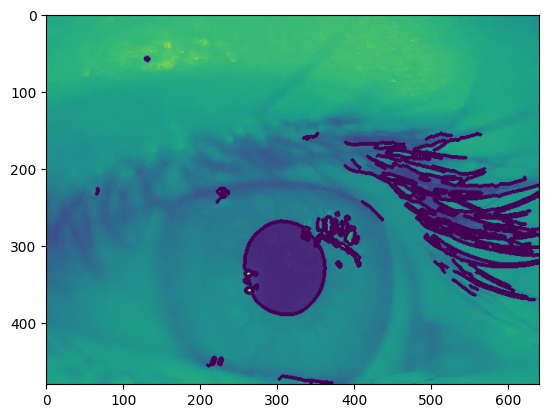

In [144]:
# Iris Localization

def iris_localization(image):

    # Apply Gaussian filtering for smoothing
    smoothed = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(smoothed, 50, 100) # Adjust the threshold as needed
    #edges = skimage.feature.canny(image, sigma=3, low_threshold=10, high_threshold=50)
    
    #plt.imshow(edges, cmap="gray")

    # Apply Hough transform for circle detection
    #circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=20, param1=50, param2=10, minRadius=10, maxRadius=150)
    
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image, contours, -1, (0, 255, 0), 3)
    plt.imshow(image)
    # ellipses = []
    # for contour in contours:
    #     if len(contour) >= 160:
    #         ellipse = cv2.fitEllipse(contour)
    #         ellipses.append(ellipse)

    # return ellipses

def draw_circles(image: np.ndarray, circles):
    for ellipse in circles:
        
        
        
        cv2.ellipse(image, ellipse, (0, 255, 0), 2)
    # if circles is not None:
    #     circles = np.round(circles[0, :]).astype("int")
    #     for (x, y, r) in circles:
    #         cv2.circle(image, (x, y), r, (0,255,0), 2)

    plt.imshow(image, cmap="gray") 
    plt.title("Iris Localization")
    plt.show()

# Test
image = cv2.imread(f"{DATASET_DIR}/1/1_396.jpg", 0) # Read as grayscale

circles = iris_localization(image)
#draw_circles(image, circles)

idea mejorar deteccion pupila.
tomar ventana de n pixeles a cada lado del centro de la elipse encontrada y verificar que el color dentro de la elipse sea negro (np.count_nonzero(window==0))


`dp`: The inverse ratio of the accumulator resolution to the image resolution. In simple terms, it represents the ratio of the image resolution to the Hough accumulator resolution. By default, dp=1 indicates that the resolution of the accumulator is the same as the input image. Increasing the value of dp can reduce the resolution of the accumulator, resulting in faster detection but potentially missing smaller circles. Decreasing the value of dp can improve the detection of smaller circles but increase computation time.

`minDist`: The minimum distance between the centers of the detected circles. This parameter defines the minimum distance (in pixels) between the centers of the circles that should be detected. If the circles are closer than this distance, only the strongest circle is detected. Increasing minDist helps in filtering out false detections by ensuring that only one circle is detected within a given neighborhood.

`param1`: The higher threshold of the Canny edge detection. This parameter sets the higher threshold for the Canny edge detector, which is used in the edge detection step. It is a crucial parameter that determines the sensitivity of the edge detection. Adjusting param1 affects the number and quality of the detected edges.

`param2`: The accumulator threshold for circle detection. This parameter sets the minimum number of votes required for a circle to be detected. The higher the param2 value, the more votes are required to consider a circle as detected. Adjusting param2 helps in filtering out false circle detections and controlling the trade-off between detection sensitivity and specificity.

`minRadius`: The minimum radius of the circles to be detected. This parameter defines the minimum radius (in pixels) of the circles to be detected. Circles with smaller radii will not be considered in the detection process.

`maxRadius`: The maximum radius of the circles to be detected. This parameter defines the maximum radius (in pixels) of the circles to be detected. Circles with larger radii will not be considered in the detection process.